### Library Import

In [104]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [105]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2, plot_roc, plot_metrics

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [106]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [107]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
print(np.array(train_images).shape)

#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

print(train_images.shape)

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]
print(input_shape)
print(train_images.shape)
print(train_labels.shape)

(1516, 100, 177, 3)
(1516, 100, 177, 3)
(100, 177, 3)
(1516, 100, 177, 3)
(1516, 1)


In [108]:
test_data_images, test_data_labels, dev_data_images, dev_data_labels, last_data_images, last_data_labels = test_train_split(test_data)

# train_images, train_labels = zip(*test_data)

test_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in test_data_images]
dev_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in dev_data_images]
last_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in last_data_images]
print(np.array(test_data_images).shape)

test_data_images, dev_data_images, last_data_images = np.array(test_data_images) / 255.0, \
                                        np.array(dev_data_images) / 255.0, \
                                        np.array(last_data_images) / 255.0

print(test_data_images.shape)                                       

test_data_images = tf.convert_to_tensor(test_data_images, dtype=tf.float32)
test_data_labels = tf.convert_to_tensor(test_data_labels, dtype=tf.float32)
dev_data_images = tf.convert_to_tensor(dev_data_images, dtype=tf.float32)
dev_data_labels = tf.convert_to_tensor(dev_data_labels, dtype=tf.float32)
last_data_images = tf.convert_to_tensor(last_data_images, dtype=tf.float32)
last_data_labels = tf.convert_to_tensor(last_data_labels, dtype=tf.float32)

print(test_data_images.shape)
print(test_data_labels.shape)

(3491, 100, 177, 3)
(3491, 100, 177, 3)
(3491, 100, 177, 3)
(3491, 1)


# Hyperparameter Tuning

In [109]:
%reload_ext tensorboard
#! rm -rf ./logs/

In [110]:
session_num = 0
epochs = 50
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 64]))#, 64])) #8, 16
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.4, 0.5))
# dropout_rate = 0.3
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop','adam','Nadam']))#,'adam', 'Nadam'])) #'sgd','Adagrad','RMSprop', 

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
modelz = []
predictions = []

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        units.append(num_units)
        dropouts.append(dropout_rate)
        optimizers.append(optimizer)
        model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, predictions,
                params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
                units, dropouts, optimizers, histories, augmentModel=True)
        modelz.append(model)
        session_num += 1

--- Starting trial: run-0
{'num_units': 32, 'dropout': 0.4, 'optimizer': 'Nadam'}
Epoch 1/50
48/48 [==============================] - 24s 467ms/step - loss: 0.8800 - accuracy: 0.5851 - f1_m: 0.6586 - precision_m: 0.5688 - recall_m: 0.8046 - val_loss: 0.5919 - val_accuracy: 0.6684 - val_f1_m: 0.6991 - val_precision_m: 0.5635 - val_recall_m: 0.9275
Epoch 2/50
48/48 [==============================] - 23s 470ms/step - loss: 0.6562 - accuracy: 0.6774 - f1_m: 0.6985 - precision_m: 0.5803 - recall_m: 0.9044 - val_loss: 0.4521 - val_accuracy: 0.7526 - val_f1_m: 0.7270 - val_precision_m: 0.5729 - val_recall_m: 1.0000
Epoch 3/50
48/48 [==============================] - 22s 462ms/step - loss: 0.5016 - accuracy: 0.7672 - f1_m: 0.7066 - precision_m: 0.5674 - recall_m: 0.9495 - val_loss: 0.4188 - val_accuracy: 0.7947 - val_f1_m: 0.7270 - val_precision_m: 0.5729 - val_recall_m: 1.0000
Epoch 4/50
48/48 [==============================] - 22s 456ms/step - loss: 0.3984 - accuracy: 0.8331 - f1_m: 0.7150 -

In [111]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, f1_scores, precisions, recalls, cms)),#aucs, 
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'f1_scores', 'precisions', 'recalls', 'cms'])#'aucs',
modelDf

,units,dropouts,optimizers,losses,accuracies,f1_scores,precisions,recalls,cms
0,32,0.4,Nadam,0.056921,0.978947,0.727019,0.572917,1.0,"[[81, 0], [4, 105]]"
1,32,0.4,RMSprop,0.041024,0.984211,0.727019,0.572917,1.0,"[[81, 0], [3, 106]]"
2,32,0.4,adam,0.045496,0.973684,0.727019,0.572917,1.0,"[[81, 0], [5, 104]]"
3,32,0.5,Nadam,0.035171,0.984211,0.727019,0.572917,1.0,"[[79, 2], [1, 108]]"
4,32,0.5,RMSprop,0.035080,0.984211,0.727019,0.572917,1.0,"[[81, 0], [3, 106]]"
5,32,0.5,adam,0.119966,0.952632,0.727019,0.572917,1.0,"[[75, 6], [3, 106]]"
6,64,0.4,Nadam,0.004578,1.000000,0.727019,0.572917,1.0,"[[81, 0], [0, 109]]"
7,64,0.4,RMSprop,0.041787,0.989474,0.727019,0.572917,1.0,"[[81, 0], [2, 107]]"
8,64,0.4,adam,0.108506,0.957895,0.727019,0.572917,1.0,"[[80, 1], [7, 102]]"
9,64,0.5,Nadam,0.013631,0.989474,0.727019,0.572917,1.0,"[[79, 2], [0, 109]]"


In [117]:
model = modelz[5]

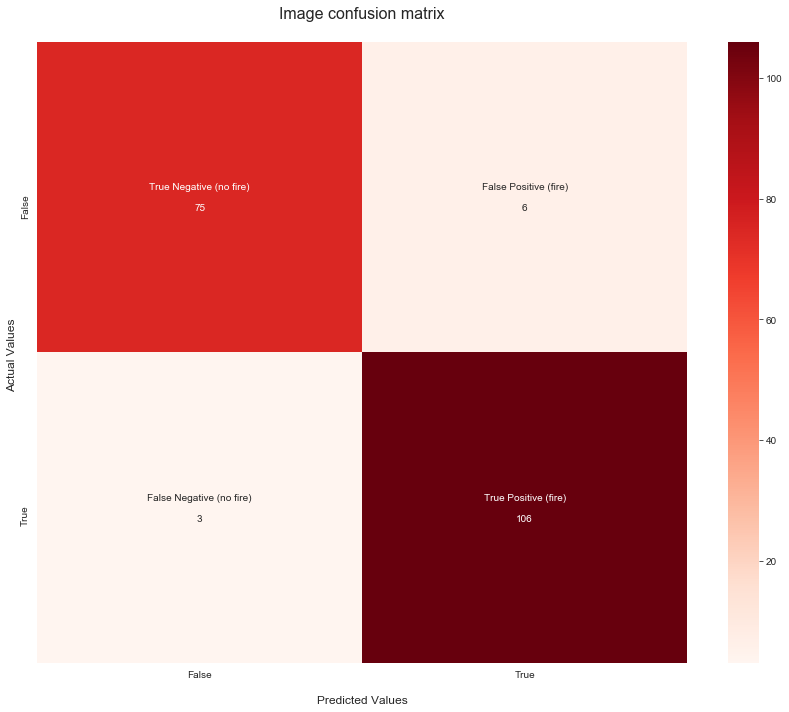

In [119]:

modelDf['cms'].values[5]

plot_confusion_matrix_2(modelDf['cms'].values[5],normalize=False)

In [120]:
# prediction = model.predict(x=test_images, steps=len(test_images), verbose=0)
# cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(prediction, axis=-1))
# print(np.argmax(prediction, axis=-1).shape)
# print(test_labels.shape)

predictions2 = model.predict(x=test_data_images, steps=len(test_data_images), verbose=0)
cm2 = confusion_matrix(y_true=test_data_labels, y_pred=np.argmax(predictions2, axis=-1))
# print(np.argmax(predictions2, axis=-1).shape)
# print(test_data_labels.shape)

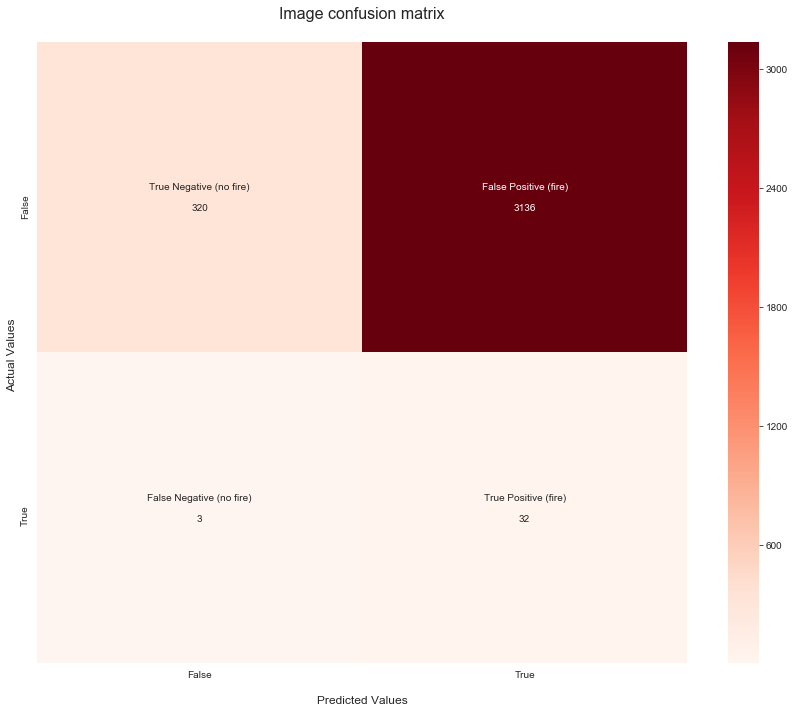

In [121]:

# modelDf['test_cms'].values[0]
# plot_confusion_matrix_2(modelDf['test_cms'].values[0],normalize=False)

plot_confusion_matrix_2(cm2,normalize=False)

In [ ]:

history_df = pd.DataFrame(histories[0].history).reset_index()
history_df

,index,loss,accuracy,f1_m,precision_m,recall_m
0,0,0.70714,0.550792,0.7145,0.568331,0.982416


In [ ]:
line_chart(history_df)

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# for i in range(len(list(modelDf.optimizers))):
#     cls = modelDf.iloc[i,2]
#     plot_confusion_matrix_2(modelDf[modelDf['optimizers']==cls]['cms'][i])
#     ax.title.set_text(type(cls).__name__)
# plt.tight_layout()  
# plt.show()

In [ ]:
# train_predictions_baseline = model.predict(train_images)
# test_predictions_baseline = model.predict(test_images)
plot_roc("Train Baseline", train_labels, predictions, color=colors[0])
plot_roc("Test Baseline", test_data_labels, predictions2, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
plot_metrics(history)